In [1]:
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter

In [2]:
# Parameters
slice_index = 30  # Hardcoded slice index
w = 7  # Neighborhood size for binary computation
z = 3  # Neighborhood size for count and mutual information
pad_width = z // 2  # Padding for neighborhoods

In [3]:
# Load .npz file
uploaded_file = '/home/mariopasc/Python/Datasets/Meningiomas/npz/meningiomas_pacientes_responsabilidades/P15/images/P15_T1.npz'  # Update this path
data = np.load(uploaded_file)
slice_data = array = np.squeeze(data['data'][0,:,:,slice_index])  # Extract hardcoded slice
# slice_data = array = np.squeeze(data['data'][0,0:127,0:127,slice_index])  # Extract hardcoded slice
n, m = slice_data.shape

In [4]:
# Apply a mean filter to the grayscale image
# A tiny bit of Gaussian noise is added to break ties so that the binary image is more random
mean_filtered = uniform_filter(slice_data, size=w) + 0.0001*np.random.normal(size=slice_data.shape)

# Binarize the image: 1 if pixel value >= mean, else 0
binarized_image = (slice_data > mean_filtered).astype(np.uint8)

In [11]:
# Compute joint frequencies

# Allocate 3D ndarray
joint_frequencies = np.zeros((n, m, 4), dtype=np.float64)

# Padding for neighborhood processing
binary_padded = np.pad(binarized_image, pad_width, constant_values=0)

# Roll to access the neighbors
binary_padded_rolled = np.roll(binary_padded, 1, axis=0)

# Fill the 3D ndarray
for i in range(n):
    for j in range(m):
        # Define z x z neighborhood
        i_start, i_end = i, i + z
        j_start, j_end = j, j + z
        neighborhood = binary_padded[i_start:i_end, j_start:j_end]

        # Original pixel values
        # pixel_value = binarized_image[i, j]
        pixel_value = binary_padded_rolled[i_start:i_end, j_start:j_end]

        # Calculate counts
        joint_frequencies[i, j, 0] = np.sum((neighborhood == 0) & (pixel_value == 0))
        joint_frequencies[i, j, 1] = np.sum((neighborhood == 1) & (pixel_value == 0))
        joint_frequencies[i, j, 2] = np.sum((neighborhood == 0) & (pixel_value == 1))
        joint_frequencies[i, j, 3] = np.sum((neighborhood == 1) & (pixel_value == 1))

# Normalize the probabilities
joint_frequencies /= (z*z)

np.max(joint_frequencies)

np.float64(1.0)

In [12]:
# Compute marginal frequencies
marginal_frequencies_pixel = np.zeros((n, m, 2), dtype=np.float64)
marginal_frequencies_pixel[:, :, 0] = joint_frequencies[:, :, 0] + joint_frequencies[:, :, 1]
marginal_frequencies_pixel[:, :, 1] = joint_frequencies[:, :, 2] + joint_frequencies[:, :, 3]

marginal_frequencies_neighbor = np.zeros((n, m, 2), dtype=np.float64)
marginal_frequencies_neighbor[:, :, 0] = joint_frequencies[:, :, 0] + joint_frequencies[:, :, 2]
marginal_frequencies_neighbor[:, :, 1] = joint_frequencies[:, :, 1] + joint_frequencies[:, :, 3]

# Compute mutual information
mutual_info = np.zeros((n, m), dtype=np.float64)
for pixel_value in range(2):
  for neighbor_value in range(2):
    denominator = marginal_frequencies_pixel[:, :, pixel_value] * \
          marginal_frequencies_neighbor[:, :, neighbor_value]
    quotient = np.divide(joint_frequencies[:, :, neighbor_value+2*pixel_value], \
                  denominator)
    logarithm = np.log(quotient)
    adding_term = joint_frequencies[:, :, neighbor_value+2*pixel_value] * logarithm
    # Find the valid entries of the array in order to avoid nans and infs
    finite_mask = np.isfinite(adding_term)

    # Accumulate for the mutual information, excluding nan and infinite values
    mutual_info[finite_mask] += adding_term[finite_mask]

np.max(mutual_info)

/tmp/ipykernel_13809/999032644.py:16: RuntimeWarning: invalid value encountered in divide
  quotient = np.divide(joint_frequencies[:, :, neighbor_value+2*pixel_value], \
/tmp/ipykernel_13809/999032644.py:18: RuntimeWarning: divide by zero encountered in log
  logarithm = np.log(quotient)
/tmp/ipykernel_13809/999032644.py:19: RuntimeWarning: invalid value encountered in multiply
  adding_term = joint_frequencies[:, :, neighbor_value+2*pixel_value] * logarithm


np.float64(0.6869615765973234)

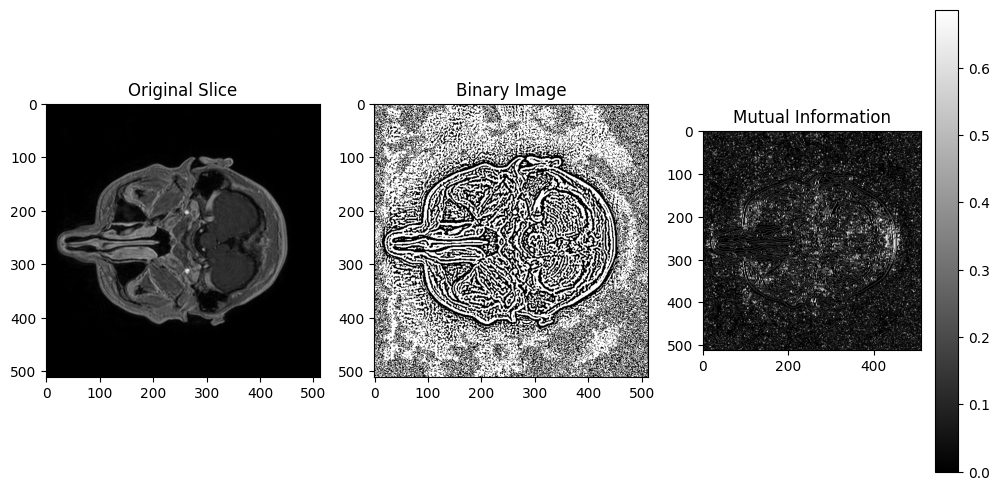

In [7]:
# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Slice")
plt.imshow(slice_data, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Binary Image")
plt.imshow(binarized_image, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Mutual Information")
plt.imshow(mutual_info, cmap='gray')
plt.colorbar()

plt.show()


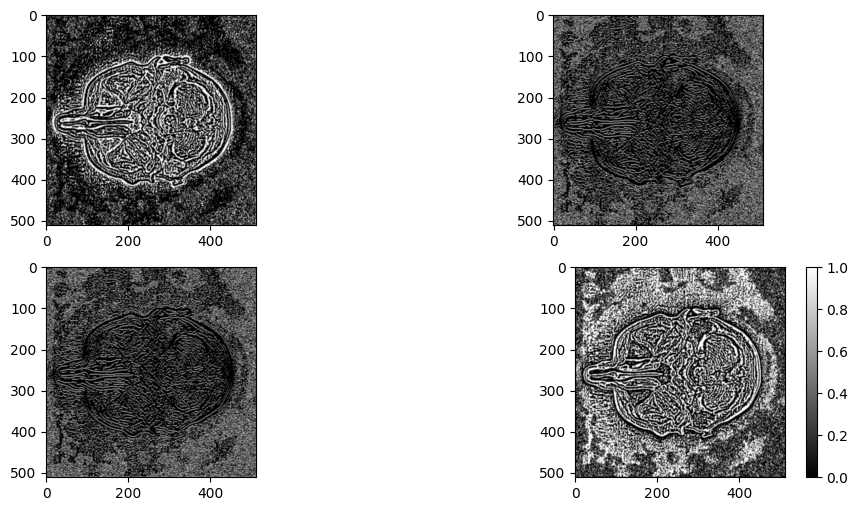

In [8]:
# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.imshow(np.squeeze(joint_frequencies[:,:,0]), cmap='gray')

plt.subplot(2, 2, 2)
plt.imshow(np.squeeze(joint_frequencies[:,:,1]), cmap='gray')

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(joint_frequencies[:,:,2]), cmap='gray')

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(joint_frequencies[:,:,3]), cmap='gray')
plt.colorbar()

plt.show()

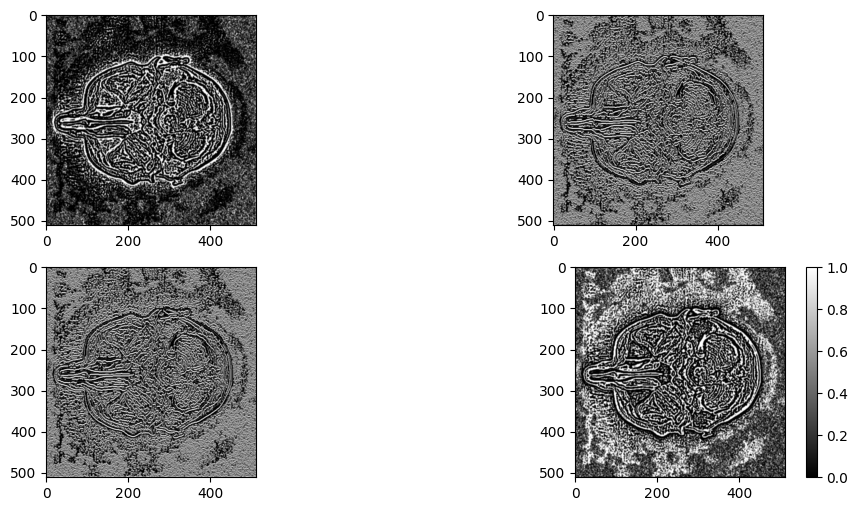

In [9]:
# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
plt.imshow(np.squeeze(marginal_frequencies_pixel[:, :,0]*marginal_frequencies_neighbor[:,:,0]), cmap='gray')

plt.subplot(2, 2, 2)
plt.imshow(np.squeeze(marginal_frequencies_pixel[:, :,0]*marginal_frequencies_neighbor[:,:,1]), cmap='gray')

plt.subplot(2, 2, 3)
plt.imshow(np.squeeze(marginal_frequencies_pixel[:, :,1]*marginal_frequencies_neighbor[:,:,0]), cmap='gray')

plt.subplot(2, 2, 4)
plt.imshow(np.squeeze(marginal_frequencies_pixel[:, :,1]*marginal_frequencies_neighbor[:,:,1]), cmap='gray')
plt.colorbar()

plt.show()

In [10]:
print(joint_frequencies[8,3,:])

[0.33333333 0.33333333 0.22222222 0.11111111]
